# 0.Introduction

The goal of the notebook is to analyze the results of American elections and plot them with use of one-way and multi-way methods. The work was split in the following chapters:
1. Data preparation: loading it libraries and data. Mergind data to have consistent structure
2. Data enrichment: adding the external demographic data to votes information
3. One-way analysis: plotting by use of one-way methods to show votes on bar graphs and geographical maps
4. Multi-way analysis: Gaussian Mixture clustering & PCA
5. Estimation: can we guess what counties vote for given parties

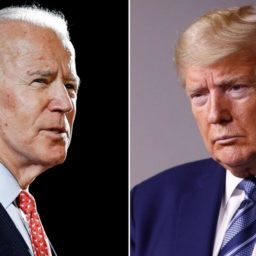

# 1.Data preparation

I will focus on preparing and cleaning the main voting data. But first let's include useful libraries:

In [ ]:
#Basic 
import numpy as np 
import pandas as pd
import collections

#Plotting 
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap as Basemap

#Regular modeling
import folium
import squarify
import matplotlib
import statsmodels.api as sm
from itertools import groupby
from operator import itemgetter
from math import sqrt

#Extended modeling
import matplotlib
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn import metrics, mixture, cluster, datasets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA,SparsePCA,KernelPCA,NMF

from mlxtend.preprocessing import minmax_scaling

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

Downloading 3 data sets. For president elections, senate and governors:

In [ ]:
df_governors = pd.read_csv('../input/us-election-2020/governors_county_candidate.csv')
df_president = pd.read_csv('../input/us-election-2020/president_county_candidate.csv')
df_senate = pd.read_csv('../input/us-election-2020/senate_county_candidate.csv')

print("The number of rows for senate: " + format(df_senate.shape[0]) + ". The number of factors: " + format(df_senate.shape[1]))
print("The number of rows for president: " + format(df_president.shape[0]) + ". The number of factors: " + format(df_president.shape[1]))
print("The number of rows for governors: " + format(df_governors.shape[0]) + ". The number of factors: " + format(df_governors.shape[1]))

Let's look at presidential one:

In [ ]:
df_president.head(5)

I will treat state and county as keys. Candidates anyway we know. New data form:

In [ ]:
df_president_agg_REP  = df_president[(df_president.party == "REP")]
df_president_agg_DEM  = df_president[(df_president.party == "DEM")]
df_president_agg_REP = pd.DataFrame(df_president_agg_REP.groupby(['state', 'county'])['total_votes'].sum())
df_president_agg_DEM = pd.DataFrame(df_president_agg_DEM.groupby(['state', 'county'])['total_votes'].sum())
df_president_agg_REP = df_president_agg_REP.rename(columns={"total_votes": "votes REP president"})
df_president_agg_DEM = df_president_agg_DEM.rename(columns={"total_votes": "votes DEM president"})

df_president_agg = pd.merge(df_president_agg_DEM, df_president_agg_REP, on=['state', 'county'],how='left')
df_president_agg.head(5)

My goal is to have all elections in one data file. I will aggregate data sets in the same way and merge together:

In [ ]:
df_senate_agg_REP  = df_senate[(df_senate.party == "REP")]
df_senate_agg_DEM  = df_senate[(df_senate.party == "DEM")]
df_senate_agg_REP = pd.DataFrame(df_senate_agg_REP.groupby(['state', 'county'])['total_votes'].sum())
df_senate_agg_DEM = pd.DataFrame(df_senate_agg_DEM.groupby(['state', 'county'])['total_votes'].sum())
df_senate_agg_REP = df_senate_agg_REP.rename(columns={"total_votes": "votes REP senate"})
df_senate_agg_DEM = df_senate_agg_DEM.rename(columns={"total_votes": "votes DEM senate"})
df_senate_agg = pd.merge(df_senate_agg_DEM, df_senate_agg_REP, on=['state', 'county'],how='outer')

df_governors_agg_REP  = df_governors[(df_governors.party == "REP")]
df_governors_agg_DEM  = df_governors[(df_governors.party == "DEM")]
df_governors_agg_REP = pd.DataFrame(df_governors_agg_REP.groupby(['state', 'county'])['votes'].sum())
df_governors_agg_DEM = pd.DataFrame(df_governors_agg_DEM.groupby(['state', 'county'])['votes'].sum())
df_governors_agg_REP = df_governors_agg_REP.rename(columns={"votes": "votes REP governors"})
df_governors_agg_DEM = df_governors_agg_DEM.rename(columns={"votes": "votes DEM governors"})
df_governors_agg = pd.merge(df_governors_agg_DEM, df_governors_agg_REP, on=['state', 'county'],how='outer')

df = pd.merge(df_president_agg, df_senate_agg, on=['state', 'county'],how='left')
df = pd.merge(df, df_governors_agg, on=['state', 'county'],how='left')
df = df.fillna(0)
df.head(5)

This is the data I would like to continue with. All the information is in the one data set. I have votes for president, senate and governors by the same keys. 

# 2.Data enrichment

This was already quite interesting data. But what I can easily do is data enrichment. Thanks to defined key (state & county), I can merge some demographic data. Let's include this census 2017 data set:

In [ ]:
df_census = pd.read_csv('../input/us-census-demographic-data/acs2017_county_data.csv')
df_census = df_census.rename(columns={"State": "state","County": "county"})
df_census.head(5)

And define the same keys:

In [ ]:
vars_to_merge = [x for x in df_census.columns if x not in ['CountyId', 'state','county']]

df_census_agg = pd.DataFrame(df_census.groupby(['state', 'county'])[vars_to_merge].sum())
df_census_agg.head(5)

Okay, merging votes data with demogrpahic data. How much NA's we have now?

In [ ]:
df = pd.merge(df, df_census_agg, on=['state', 'county'],how='left')

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

Quite a lot. Why? Some small counties, like in Alaska or deeply in dessert where out of this data set. I will keep this structure for time being, but I will make a list of counties which have nulls:

In [ ]:
df_null = df[df.isnull().any(axis=1)]
Null_county = np.array(df_null.index.get_level_values('county'))
Null_county

Furthermore, number of votes is nice number but it really makes better sense to rewrite it in percentage form, for example: republican_votes / (all votes). For the moment, I replace all NA's with 0's.

In [ ]:
df['votes REP president perc'] = df['votes REP president']  / (df['votes REP president']+df['votes DEM president'])
df['votes DEM president perc'] = df['votes DEM president']  / (df['votes REP president']+df['votes DEM president'])
df['votes REP senate perc'] = df['votes REP senate']  / (df['votes REP senate']+df['votes DEM senate'])
df['votes DEM senate perc'] = df['votes DEM senate']  / (df['votes REP president']+df['votes DEM senate'])
df['votes REP governors perc'] = df['votes REP governors']  / (df['votes REP governors']+df['votes DEM governors'])
df['votes DEM governors perc'] = df['votes DEM governors']  / (df['votes REP governors']+df['votes DEM governors'])

votes_perc = df.iloc[:,-6:].columns
votes = [x for x in df.columns if x not in df_census_agg.columns]
factors = [x for x in df.columns if x not in votes]
df = df.fillna(0)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

Our final data:

In [ ]:
print('Number of rows: '+ format(df.shape[0]) +', number of features: '+ format(df.shape[1]))

And the check for data types:

In [ ]:
C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)

Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)
print('Number of numeric variables: '+ format(len(NumericVariables)) +', number of categorical features: '+ format(len(CategoricalVariables)))

Easy, then I can continue with numeric variables without need of dummy transformation or ordinal one.

# 3.One-way analysis

Once the data is prepared, cleaned and enriched, I can focus on some visualizations. First, let's scale the data. It will be useful for PCA and clustering in the further part:

In [ ]:
df_final = minmax_scaling(df, columns=df.columns)
df_final.head(5)

Let's look at Spearman correlation: (why not Pearson? [Here explanation](https://www.kaggle.com/jjmewtw/yt-pearson-spearman-distance-corr-rv-coef)):

In [ ]:
SpearmanCorr = df_final.corr(method="spearman")
x = SpearmanCorr[votes_perc]
matplotlib.pyplot.figure(figsize=(15,20))
sns.heatmap(x, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

Interesting observations:
* Republican president's vote are really correlated with race. He receives votes mostly from white people. Moreover his votes come from people with low income, non self-employed
* Democratic president has majority of correlation perfectly opposite

I plot percentages of votes by states:

In [ ]:
color_1 = plt.cm.Reds(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Blues(np.linspace(0.6, 1, 66))

states = df.groupby('state').agg({'votes REP president':'sum','votes DEM president':'sum'}).sort_values(by='state',ascending=False)
states['Total votes'] = states['votes REP president'] + states['votes DEM president']
states['votes REP president perc'] = states['votes REP president'] / states['Total votes']
states['votes DEM president perc'] = states['votes DEM president'] / states['Total votes']

data1 = states['votes REP president perc']
data2 = states['votes DEM president perc']

plt.figure(figsize=(16,8))
x = np.arange(51)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Number of votes by political party')
plt.xticks(x + w /2, data1.index, rotation=-90)
ax1.set_xlabel('States')
ax1.set_ylabel('Percentage of votes')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

color = color_2
ax2 = ax1
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

Wyoming is the Republican paradise, while DC Columbia is democratic one. I look at them also on the map:

In [ ]:
fig = plt.figure(figsize=(20, 16), dpi=70, facecolor='w', edgecolor='k')

ax = fig.add_subplot(211)
ax.set_title("Republicans votes")
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

shp_info = m.readshapefile('../input/basemaps/st99_d00','states',drawbounds=True)

colors={}
statenames=[]
cmap = plt.cm.Reds 
vmin = min(data1); vmax = max(data1)
for shapedict in m.states_info:
    statename = shapedict['NAME']
    if statename not in ['District of Columbia','Puerto Rico']:
        pop = data1[statename]

        colors[statename] = cmap(np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
ax = plt.gca() 
for nshape,seg in enumerate(m.states):
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)

ax = fig.add_subplot(212)
ax.set_title("Democrats votes")
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

shp_info = m.readshapefile('../input/basemaps/st99_d00','states',drawbounds=True)

colors={}
statenames=[]
cmap = plt.cm.Blues 
vmin = min(data2); vmax = max(data2)
for shapedict in m.states_info:
    statename = shapedict['NAME']
    if statename not in ['District of Columbia','Puerto Rico']:
        pop = data2[statename]

        colors[statename] = cmap(np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
ax = plt.gca() 
for nshape,seg in enumerate(m.states):
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly) 

plt.show()

Two big states (California and Texas) remain the centers of power of opposing parties. Middle part of country is kingdom of Republicans. Coasts prefer Democrats. Nothing surprising, but good check whther data makes sense.

# 4.Multi-way

Now I want to look in a bit more granular way. I would like to capture some interesting multi-dimensional trends. First clustering, precisely GM clustering ([more information here](https://www.kaggle.com/jjmewtw/clustering-k-means-hierarchical-debscan-ema)). First, using Akaike I assess what would be the perfect number of clusters. Using legendary 'elbow rule', I would say something like 2 clusters:

In [ ]:
X = df_final[factors].values

GM_n_components = np.arange(1, 15)
GM_models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in GM_n_components]

plt.figure(num=None, figsize=(8, 6), dpi=60, facecolor='w', edgecolor='r')
plt.plot(GM_n_components, [m.aic(X) for m in GM_models], label='AIC')
plt.tight_layout()
plt.legend(loc='best')
plt.xlabel('n_components');

Indeed, as I am interested in finding wheather cluster captures differences between Republicans and Democrats I impose only two of them:

In [ ]:
GM_n_classes = 2

GMcluster = mixture.GaussianMixture(n_components=GM_n_classes, covariance_type='full',random_state = 0)
GMcluster_fit = GMcluster.fit(df_final)
GMlabels = GMcluster_fit.predict(df_final)

print('Number of clusters: ' + format(len(np.unique(GMlabels))))

In [ ]:
unique, counts = np.unique(GMlabels, return_counts=True)
dict(zip(unique, counts))

And plotting it in 3 dimensions:

In [ ]:
fig = plt.figure(figsize=(8, 6),facecolor='w', edgecolor='r')
ax = p3.Axes3D(fig, rect = (1, 1, 1, 1))
ax.set_xlim3d(0.2, 0.8)
ax.set_ylim3d(0.2, 0.45)
ax.set_zlim3d(0.2, 0.8)
ax.view_init(10, 40)
for l in np.unique(GMlabels):
    ax.scatter(X[GMlabels == l, 0], X[GMlabels == l, 1], X[GMlabels == l, 2],color=plt.cm.jet(float(l) / np.max(GMlabels + 1)),s=20, edgecolor='k')
plt.title('Expectation-maximization algorithm for business features clustering' )

plt.show()

Let's add this cluster to the data, maybe it will be useful:

In [ ]:
df_final['Party_Cluster'] = GMlabels

Please notice, that clustering is unsupervised method. It means that I didn't tell it what it tries to predict. It just grouped some behaviours observed in the data.

Next method is PCA ([more information here](https://www.kaggle.com/jjmewtw/total-analysis-of-pca-sparse-pca-nmf-kernel-pca)). I will explore, whether it is possible to create linear transformation of the given data to capture all the infromation. In this case, I use whole data set (votes + demographic), why? I would like to explore whether demographic information is sufficient to capture all trends, or some information is only present in voting data set. The distribution of explained variance:

In [ ]:
pca = PCA().fit(df_final)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=70, facecolor='w', edgecolor='k')
ax0, ax1 = axes.flatten()

sns.set('talk', palette='colorblind')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

ax0.plot(np.cumsum(pca.explained_variance_ratio_), marker='.')
ax0.set_xlabel('Number of components')
ax0.set_ylabel('Cumulative explained variance');

ax1.bar(range(df_final.shape[1]),pca.explained_variance_)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Explained variance');

plt.tight_layout()
plt.show()

How many PC's we need:

In [ ]:
n_PCA_90 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.9) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.9)
print("Already: " + format(n_PCA_90) + " components cover 90% of variance.")

Good result for linear transformation. Breaking it down further. I want to check what variables contribute the most to these top 5 components:

In [ ]:
pca = PCA(5).fit(df_final)

X_pca=pca.transform(df_final) 

plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3,4,5],['1st Comp','2nd Comp','3rd Comp','4th Comp','5th Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df_final.columns)),df_final.columns,fontsize=10,rotation=90)
plt.tight_layout()
plt.show()

Presenting it in table, only the most contributing variables:

In [ ]:
PCA_vars = [0]*len(df_final.columns)

def ExtractColumn(lst,j): 
    return [item[j] for item in lst] 

for i, feature in zip(range(len(df_final.columns)),df_final.columns):
    x = ExtractColumn(pca.components_,i)
    if ((max(x) > 0.2) | (min(x) < -0.2)):
        if abs(max(x)) > abs(min(x)):
            PCA_vars[i] = max(x)
        else:
            PCA_vars[i] = min(x)                 
    else:
        PCA_vars[i] = 0

PCA_vars = pd.DataFrame(list(zip(df_final.columns,PCA_vars)),columns=('Name','Max absolute contribution'),index=range(1,48,1))      
PCA_vars = (PCA_vars[(PCA_vars['Max absolute contribution']!=0)]).sort_values(by='Max absolute contribution',ascending=False)
PCA_vars

Conclusions:
* a lot of information is present only in voting data set. In other words, it will be hard to predict votes by demographic data
* 'Party cluster' built only on the basis of demographic data is quite useful
* race is a big thing in the data set

# 5.Estimation

Final chapter: I want to predict how republican / democratic given county is on the basis of demographic data. For this I define my response as sum of percentage votes on republican candidates for presidential, senate, governor elections. To keep it between 0 and 1, I scale it. In this way it is easier explainable. 

In [ ]:
df_final_estimation = df_final.drop(Null_county, level='county')

Response = pd.DataFrame(df_final_estimation['votes REP president perc'] + df_final_estimation['votes REP senate perc'] + df_final_estimation['votes REP governors perc'],columns=["Response"])
Response = minmax_scaling(Response, columns=Response.columns)
#df_final['ResponseDEM'] = df_final['votes DEM president perc'] + df_final['votes DEM senate perc'] + df_final['votes DEM governors perc']

df_final_estimation = df_final_estimation.drop(votes, axis=1)

x_train,x_test,y_train,y_test = train_test_split(df_final_estimation,Response,test_size=0.2,random_state=0)

As it is type of best rpactice, my first model is 'average'. I just calculate average value for Repsonse on my train data set:

In [ ]:
ModelAverage = y_train.mean()
print(str(round(ModelAverage,5)))

I define final test data set:

In [ ]:
RMSE = y_test
RMSE.insert(1, "Model_Average", ModelAverage.values[0], True)
y_test=y_test.drop(['Model_Average'], axis=1)
RMSE.head(5)

First real model will be Generalized Linear Model. Let's assume Gaussianity for time being:

In [ ]:
Model_GLM = sm.GLM(y_train, x_train,family=sm.families.Gaussian())

Model_GLM_fit = Model_GLM.fit()

print(Model_GLM_fit.summary())

Also added to the test data set:

In [ ]:
RMSE.insert(2, "Model_GLM", Model_GLM_fit.predict(x_test).values, True)

Further, one of the most popular models in Kaggle: extreme boosting. For this I define my own cross validation with the given space and CV function:

In [ ]:
space={ 'max_depth': hp.quniform("max_depth", 2,25,1),
        'alpha': hp.uniform ('alpha', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 25, 1),
        'learning_rate' : hp.uniform('learning_rate', 0.00001, 0.8),
        'n_estimators': 500,
        'seed': 0}

def f_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

def objective(space):
    clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), alpha = space['alpha'],
                        learning_rate = space['learning_rate'],min_child_weight=space['min_child_weight'],colsample_bytree=space['colsample_bytree'])

    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf_fit = clf.fit(x_train, y_train,verbose=False,eval_set=evaluation,early_stopping_rounds=20)
    
    pred = clf_fit.predict(x_test)
    score = f_rmse(RMSE['Response'].values, pred)
    print(format(score))
    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,space = space,algo = tpe.suggest,max_evals = 100,trials = trials)

I print best hyperparameters:

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

And include them to calibrated xgb:

In [ ]:
Model_XGB = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7046466436203225, learning_rate = 0.02192155309970599,
                max_depth = 16, alpha = 0.4135415520098815, n_estimators = 300,min_child_weight=14)

Model_XGB_fit = Model_XGB.fit(x_train,y_train)

Plotting the tree as an example:

In [ ]:
xgb.plot_tree(Model_XGB_fit,num_trees=0)
plt.rcParams['figure.figsize'] = [80,50]
plt.show()

And importance. One can compare it with GLM importance:

In [ ]:
xgb.plot_importance(Model_XGB_fit)
plt.rcParams['figure.figsize'] = [12, 10]
plt.show()

Race is a big thing again. I add these reults to the main table:

In [ ]:
RMSE.insert(3, 'Model_XGB', Model_XGB_fit.predict(x_test), True)
RMSE.head(5)

Add the end I look at RMSE (Root Mean Square Error):

In [ ]:
Model_Average_RMSE =     f_rmse(RMSE['Response'].values, RMSE['Model_Average'].values)   
Model_GLM_RMSE =      f_rmse(RMSE['Response'].values, RMSE['Model_GLM'].values)    
Model_XGB_RMSE =      f_rmse(RMSE['Response'].values, RMSE['Model_XGB'].values)  

Results = pd.DataFrame({'RMSE': [Model_Average_RMSE,Model_GLM_RMSE,Model_XGB_RMSE],'Name': ['Model_Average','Model_GLM','Model_XGB']})
Results = Results.set_index('Name')

plt.plot(Results)
plt.ylabel('RMSE results')
plt.show()

To sum up: extreme boosting performs the best, that's true. But still for example difference between GLM and just average is neglectable. Probably because Gaussianity is wrong assumption, also the link is identical, I could think about some calibration of GLM. All in all, we can see that we can more less predict how counties vote, but the margin of error is really big.

**Please upvote if you like it :)**

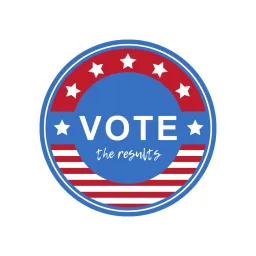